In [1]:
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
from sklearn.utils import resample
from scipy.signal import resample as scipy_resample
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score,confusion_matrix
random_seed = 1024
import numpy as np # linear algebra
np.random.seed(random_seed) 


# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input/heartbeat'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

/kaggle/input/heartbeat/ptbdb_abnormal.csv
/kaggle/input/heartbeat/ptbdb_normal.csv
/kaggle/input/heartbeat/mitbih_test.csv
/kaggle/input/heartbeat/mitbih_train.csv


In [2]:
# Data Exploration (MIT-BIH)
mitbih_train_loc = "/kaggle/input/heartbeat/mitbih_train.csv"
mitbih_test_loc = "/kaggle/input/heartbeat/mitbih_test.csv"
mitbih_train_df = pd.read_csv(mitbih_train_loc, header=None)
mitbih_test_df = pd.read_csv(mitbih_test_loc, header=None)

dataset = pd.concat([mitbih_train_df, mitbih_test_df], axis=0, sort=True).reset_index(drop=True)

In [3]:
labels = dataset.iloc[:, -1].astype('category').map({
    0: 'N - Normal Beat', 
    1: 'S - Supraventricular premature or ectopic beat',
    2: 'V - Premature ventricular contraction', 
    3: 'F - Fusion of ventricular and normal beat', 
    4: 'Q - Unclassified beat'}) 

# since the last column is the category
obs = np.array(dataset.iloc[:, :187]) 

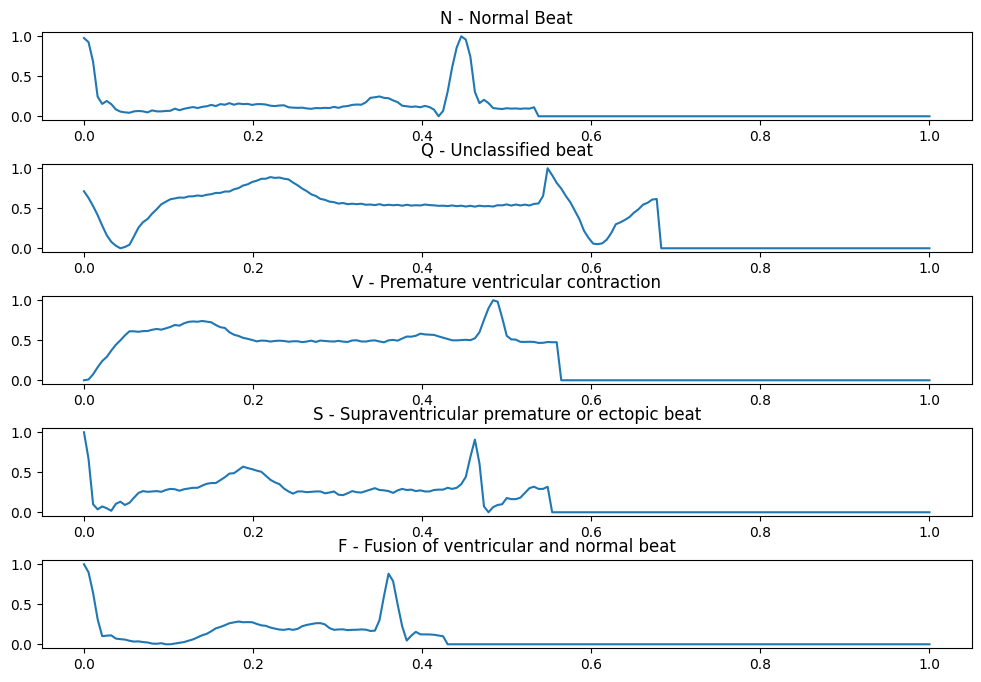

In [4]:
# get the indexes of all labels
n_indexes = labels.index[labels == 'N - Normal Beat']
q_indexes = labels.index[labels == 'Q - Unclassified beat']
v_indexes = labels.index[labels == 'V - Premature ventricular contraction']
s_indexes = labels.index[labels == 'S - Supraventricular premature or ectopic beat']
f_indexes = labels.index[labels == 'F - Fusion of ventricular and normal beat']

# sample one observation per class by indexing the train_labels
n_index = n_indexes[0]
q_index = q_indexes[0]
v_index = v_indexes[0]
s_index = s_indexes[0]
f_index = f_indexes[0]

def generate_subplot(figure, obs, gridspec, row, col, title):
    axis = figure.add_subplot(gridspec[row, col])
    axis.plot(np.linspace(0, 1, obs.shape[0]), obs)
    axis.set_title(title)

# Plot samples
fig = plt.figure(figsize=(12, 8))
fig.subplots_adjust(hspace=0.5, wspace=0.001)
gs = fig.add_gridspec(5, 1)

generate_subplot(fig, obs[n_index], gs, 0, 0, 'N - Normal Beat')
generate_subplot(fig, obs[q_index], gs, 1, 0, 'Q - Unclassified beat')
generate_subplot(fig, obs[v_index], gs, 2, 0, 'V - Premature ventricular contraction')
generate_subplot(fig, obs[s_index], gs, 3, 0, 'S - Supraventricular premature or ectopic beat')
generate_subplot(fig, obs[f_index], gs, 4, 0, 'F - Fusion of ventricular and normal beat')

plt.show()

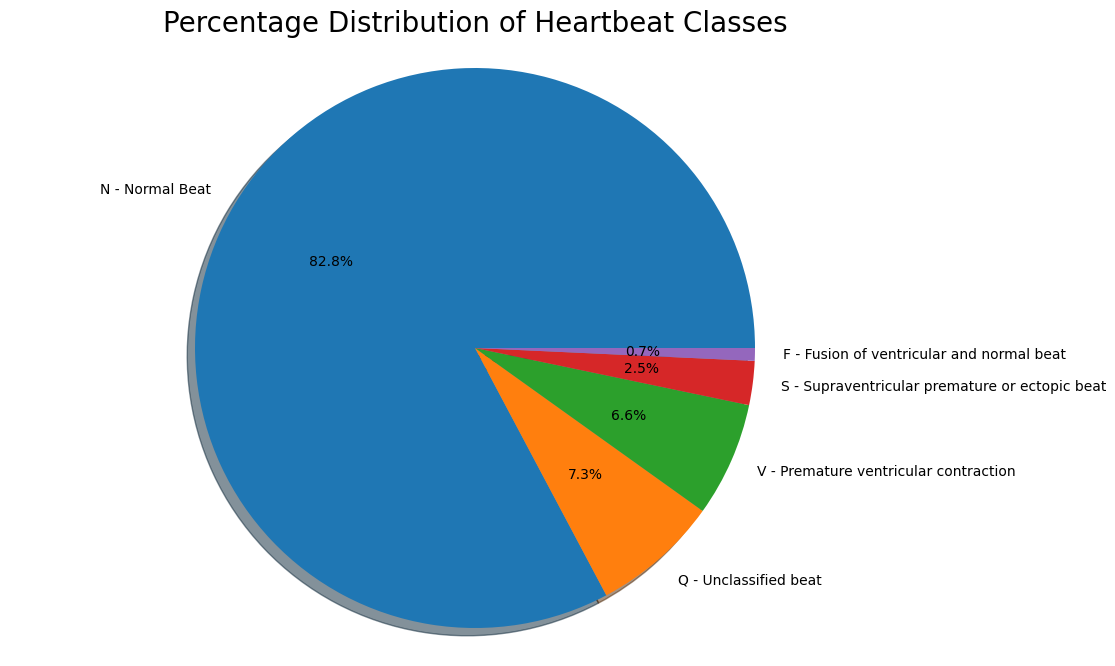

In [5]:
observation_counts = labels.value_counts()
labels_descending = np.array(observation_counts.keys())

fig1, ax1 = plt.subplots()
ax1.pie(observation_counts, labels=labels_descending, autopct='%1.1f%%', startangle=0, shadow=True)
ax1.axis('equal')
fig1.set_size_inches(12,8)
ax1.set_title("Percentage Distribution of Heartbeat Classes", fontsize=20)
plt.show()

In [6]:
print(observation_counts)

187
N - Normal Beat                                   90589
Q - Unclassified beat                              8039
V - Premature ventricular contraction              7236
S - Supraventricular premature or ectopic beat     2779
F - Fusion of ventricular and normal beat           803
Name: count, dtype: int64


In [7]:
from sklearn.utils import resample

random_seed = 42  # Or any seed value you want

# Resample indexes of each class
n_indexes_resampled = resample(n_indexes, replace=True, n_samples=10000, random_state=random_seed)
q_indexes_resampled = resample(q_indexes, replace=True, n_samples=10000, random_state=random_seed)
v_indexes_resampled = resample(v_indexes, replace=True, n_samples=10000, random_state=random_seed)
s_indexes_resampled = resample(s_indexes, replace=True, n_samples=10000, random_state=random_seed)
f_indexes_resampled = resample(f_indexes, replace=True, n_samples=10000, random_state=random_seed)

# Initialize the labels_resampled to empty pandas Series
labels_resampled = pd.Series(dtype=labels.dtype)

# Initialize obs_resampled as an empty array with the correct number of features
obs_resampled = np.empty((0, obs.shape[1]), dtype=obs.dtype)

# List of resampled indexes
label_indexes_list = [n_indexes_resampled, 
                      q_indexes_resampled, 
                      v_indexes_resampled, 
                      s_indexes_resampled, 
                      f_indexes_resampled]

for label_indexes in label_indexes_list:
    # Append labels for all resampled classes
    labels_resampled = pd.concat([labels_resampled, labels[label_indexes]], ignore_index=True)
    
    # Append observations for all resampled classes
    obs_resampled = np.concatenate((obs_resampled, obs[label_indexes]), axis=0)

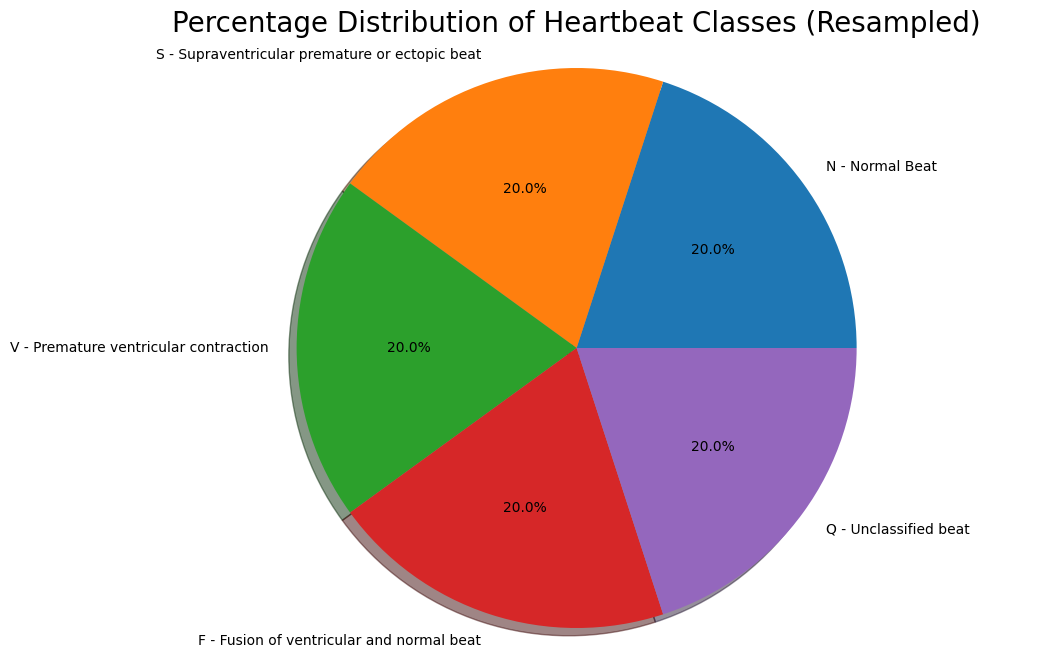

In [8]:
observation_counts = labels_resampled.value_counts()
labels_descending = np.array(observation_counts.keys())

fig1, ax1 = plt.subplots()
ax1.pie(observation_counts, labels=labels_descending, autopct='%1.1f%%', startangle=0, shadow=True)
ax1.axis('equal')
fig1.set_size_inches(12,8)
ax1.set_title("Percentage Distribution of Heartbeat Classes (Resampled)", fontsize=20)
plt.show()

In [9]:
print(observation_counts)

N - Normal Beat                                   10000
S - Supraventricular premature or ectopic beat    10000
V - Premature ventricular contraction             10000
F - Fusion of ventricular and normal beat         10000
Q - Unclassified beat                             10000
Name: count, dtype: int64


In [10]:
from scipy.signal import resample

# first version of adding random noise (Gaussian Noise)
mean = 0
std = 0.05
def add_gaussian_noise(signal):
    noise = np.random.normal(mean, std, signal.shape)
    return signal + noise

def stretch(x):
    l = int(x.shape[0] * (1 + (random.random() - 0.5) / 3))
    y = scipy_resample(x, l)
    if l < x.shape[0]:
        y_ = np.zeros(x.shape)
        y_[:l] = y
    else:
        y_ = y[:x.shape[0]]
    return y_

def amplify(x):
    alpha = (random.random() - 0.5)
    factor = -alpha * x + (1 + alpha)
    return x * factor

def add_amplify_and_stretch_noise(x):
    if random.random() < 0.33:
        return stretch(x)
    elif random.random() < 0.66:
        return amplify(x)
    else:
        return amplify(stretch(x))

obs_resampled_with_noise_1 = np.array([add_gaussian_noise(obs) for obs in obs_resampled])
obs_resampled_with_noise_2 = np.array([add_amplify_and_stretch_noise(obs) for obs in obs_resampled])

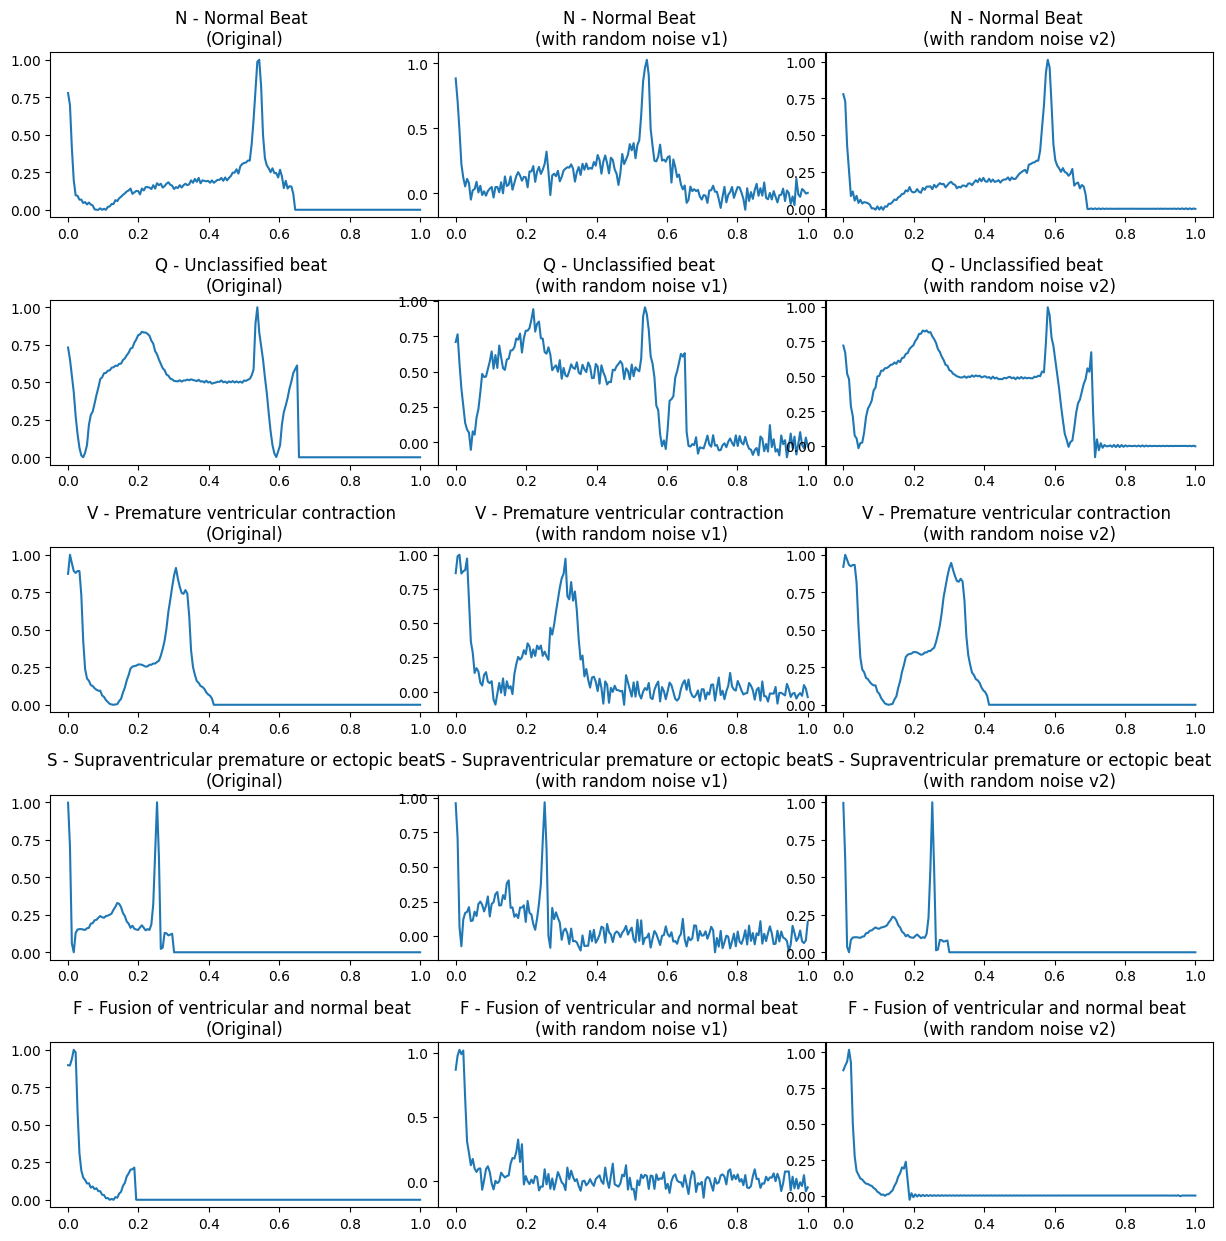

In [11]:
def generate_plots_for_a_specific_data_augmentation(obs_resampled, obs_resampled_with_noise_1, obs_resampled_with_noise_2):
    # Sample one observation per class by indexing the train_labels
    n_index = 0
    q_index = 10000
    v_index = 20000
    s_index = 30000
    f_index = 40000
    
    fig = plt.figure(figsize=(15, 15))
    fig.subplots_adjust(hspace=0.5, wspace=0.001)
    gs = fig.add_gridspec(5, 3)

    generate_subplot(fig, obs_resampled[n_index], gs, 0, 0, 'N - Normal Beat \n(Original)')
    generate_subplot(fig, obs_resampled_with_noise_1[n_index], gs, 0, 1, 'N - Normal Beat \n(with random noise v1)')
    generate_subplot(fig, obs_resampled_with_noise_2[n_index], gs, 0, 2, 'N - Normal Beat \n(with random noise v2)')
    generate_subplot(fig, obs_resampled[q_index], gs, 1, 0, 'Q - Unclassified beat \n(Original)')
    generate_subplot(fig, obs_resampled_with_noise_1[q_index], gs, 1, 1, 'Q - Unclassified beat \n(with random noise v1)')
    generate_subplot(fig, obs_resampled_with_noise_2[q_index], gs, 1, 2, 'Q - Unclassified beat \n(with random noise v2)')
    generate_subplot(fig, obs_resampled[v_index], gs, 2, 0, 'V - Premature ventricular contraction \n(Original)')
    generate_subplot(fig, obs_resampled_with_noise_1[v_index], gs, 2, 1, 'V - Premature ventricular contraction \n(with random noise v1)')
    generate_subplot(fig, obs_resampled_with_noise_2[v_index], gs, 2, 2, 'V - Premature ventricular contraction \n(with random noise v2)')
    generate_subplot(fig, obs_resampled[s_index], gs, 3, 0, 'S - Supraventricular premature or ectopic beat \n(Original)')
    generate_subplot(fig, obs_resampled_with_noise_1[s_index], gs, 3, 1, 'S - Supraventricular premature or ectopic beat \n(with random noise v1)')
    generate_subplot(fig, obs_resampled_with_noise_2[s_index], gs, 3, 2, 'S - Supraventricular premature or ectopic beat \n(with random noise v2)')
    generate_subplot(fig, obs_resampled[f_index], gs, 4, 0, 'F - Fusion of ventricular and normal beat \n(Original)')
    generate_subplot(fig, obs_resampled_with_noise_1[f_index], gs, 4, 1, 'F - Fusion of ventricular and normal beat \n(with random noise v1)')
    generate_subplot(fig, obs_resampled_with_noise_2[f_index], gs, 4, 2, 'F - Fusion of ventricular and normal beat \n(with random noise v2)')

    plt.show()

generate_plots_for_a_specific_data_augmentation(obs_resampled, obs_resampled_with_noise_1, obs_resampled_with_noise_2)

In [12]:
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score

# Prepare the final dataset for training
obs_resampled_final = np.concatenate((obs_resampled, obs_resampled_with_noise_1, obs_resampled_with_noise_2), axis=0)
labels_resampled_final = pd.concat([labels_resampled, labels_resampled, labels_resampled], ignore_index=True)

# Convert labels to numeric format (if not already)
label_mapping = {label: idx for idx, label in enumerate(labels_resampled_final.unique())}
labels_numeric = labels_resampled_final.map(label_mapping).values

# Split the data
X_train, X_test, y_train, y_test = train_test_split(obs_resampled_final, labels_numeric, test_size=0.2, random_state=42)

# Define the neural network model
model = tf.keras.Sequential([
    tf.keras.layers.Dense(128, activation='relu', input_shape=(X_train.shape[1],)),
    tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(len(label_mapping), activation='softmax')
])

# Compile the model
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Train the model
history = model.fit(X_train, y_train, epochs=300, validation_split=0.2, batch_size=100)

# Make predictions
y_pred_probs = model.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred, target_names=label_mapping.keys())

# Print the results
print(f'Test Accuracy (Overall): {accuracy * 100:.2f}%')
print(report)

# Generate individual class accuracies
unique_labels = np.unique(y_test)
class_accuracies = {}

for label in unique_labels:
    label_idx = (y_test == label)
    class_accuracy = accuracy_score(y_test[label_idx], y_pred[label_idx])
    class_accuracies[label] = class_accuracy

for label, acc in class_accuracies.items():
    print(f'Test Accuracy of {list(label_mapping.keys())[label]}: {acc * 100:.2f}% ({sum(y_test == label)}/{len(y_test)})')


2024-07-29 09:13:25.488594: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-29 09:13:25.488797: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-29 09:13:25.709070: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/300
960/960 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.7370 - loss: 0.7305 - val_accuracy: 0.8544 - val_loss: 0.3896
Epoch 2/300
960/960 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.8667 - loss: 0.3613 - val_accuracy: 0.8931 - val_loss: 0.3035
Epoch 3/300
960/960 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.8955 - loss: 0.2905 - val_accuracy: 0.9105 - val_loss: 0.2560
Epoch 4/300
960/960 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.9107 - loss: 0.2499 - val_accuracy: 0.9189 - val_loss: 0.2321
Epoch 5/300
960/960 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.9221 - loss: 0.2195 - val_accuracy: 0.9226 - val_loss: 0.2224
Epoch 6/300
960/960 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.9289 - loss: 0.2003 - val_accuracy: 0.9315 - val_loss: 0.1971
Epoch 7/300
960/960 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.9358 - loss: 0.1816 - val_accuracy: 0.9364 - val_loss: 0.1873
Epoch 8/300
960/960 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.9412 - loss: 0.1698 - val_accu

In [13]:
from sklearn.metrics import confusion_matrix

# Prepare the mapping for the labels
label_mapping = {label: idx for idx, label in enumerate(labels_resampled.unique())}
labels_numeric = labels_resampled_final.map(label_mapping).values

# Calculate the confusion matrix
cm = confusion_matrix(y_test, y_pred, labels=list(label_mapping.values()))

print("Confusion Matrix:")
print(cm)

Confusion Matrix:
[[5687   19   49  172   55]
 [  20 5904   15   17    3]
 [  53   15 5802   29   84]
 [ 244    9   20 5696   17]
 [ 126   10   89   24 5841]]


In [14]:
cm

array([[5687,   19,   49,  172,   55],
       [  20, 5904,   15,   17,    3],
       [  53,   15, 5802,   29,   84],
       [ 244,    9,   20, 5696,   17],
       [ 126,   10,   89,   24, 5841]])